In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tifffile as tf
from glob import glob
import os
from scipy import ndimage, interpolate, spatial, stats

from KDEpy import FFTKDE
import gudhi as gd
import json

In [2]:
def kde_grid_generator(stepsize, maxdims, pows2 = 2**np.arange(20) + 1, pad=1.5):
    axes = [ np.arange(0, maxdims[i], stepsize) for i in range(len(maxdims)) ]
    AXES = [ None for i in range(len(axes)) ]
    
    for i in range(len(axes)):
        m = np.nonzero(pows2 > pad*len(axes[i]))[0][0]
        foo = pows2[m] - len(axes[i])
        neg = foo//2
        pos = np.where(foo%2==0, foo//2, foo//2 + 1) + 0
        AXES[i] = np.hstack((np.arange(-neg, 0, 1)*stepsize, axes[i], np.arange(len(axes[i]), len(axes[i])+pos, 1)*stepsize))
    
    AXES = np.meshgrid(*AXES, indexing='ij')
    grid = np.column_stack([ np.ravel(AXES[i]) for i in range(len(AXES)) ])
    
    mask = np.ones(len(grid), dtype=bool)
    for i in range(len(axes)):
        mask = mask & (grid[:,i] >= 0) & (grid[:,i] < maxdims[i])

    return axes, grid, mask

def cardinal_distance_transform(img):
    PAD = 1
    pss = np.s_[PAD:-PAD,PAD:-PAD]
    pad = np.pad(img, PAD, constant_values=0)
    initd = np.full(pad.shape, max(pad.shape)+1, dtype=int)
    initd[~pad] = 0
    left = np.copy(initd)
    for j in range(1,pad.shape[1]):
        left[:, j] = np.minimum(left[:, j], left[:, j-1] + 1)
    right = np.copy(initd)
    for j in range(pad.shape[1]-2, -1, -1):
        right[:, j] = np.minimum(right[:, j], right[:, j+1] + 1)
    bottom = np.copy(initd)
    for j in range(1,pad.shape[0]):
        bottom[j] = np.minimum(bottom[j], bottom[j-1] + 1)
    top = np.copy(initd)
    for j in range(pad.shape[0]-2, -1, -1):
        top[j] = np.minimum(top[j], top[j+1] + 1)

    return top[pss], right[pss], bottom[pss], left[pss]

In [3]:
pows2 = 2**np.arange(20) + 1
fs = 15
bw = 10
PP = 6
stepsize = 3
pp = 0

wsrc = '../cell_dams/'
nsrc = '../nuclear_mask/'
tsrc = '../translocs/'
psrc = '../proc/'
osrc = '../data/'
ksrc = '../kde/'
sample = 'D2'

dst = '../suplevel/'
figdst = os.path.expanduser('~') + '/documents/website/mcarto/figs/'

ksrc += sample + os.sep
dst += sample + os.sep
if not os.path.isdir(dst):
    os.mkdir(dst)

# Load all general data

In [5]:
wall = tf.imread(wsrc + sample + '_dams.tif').astype(bool)
label, cellnum = ndimage.label(wall, ndimage.generate_binary_structure(2,1))

wall[tf.imread(nsrc + sample + '_EDT.tif') < 2] = False
print('Detected',cellnum,'cells')

metacell = pd.read_csv(ksrc + sample + '_cells_metadata.csv')
metatrans = pd.read_csv(ksrc + sample + '_transcripts_metadata.csv')
transcell = pd.read_csv(ksrc + sample + '_transcells_metadata.csv')
tcumsum = np.hstack(([0], np.cumsum(metatrans['cyto_number'].values)))

transcriptomes = list(metatrans['gene'])
translocs = [None for i in range(len(transcriptomes))]
for i in range(len(transcriptomes)):
    filename = tsrc + sample + os.sep + 'location_corrected_D2_-_' + transcriptomes[i] + '.csv'
    translocs[i] = pd.read_csv(filename, header=None, names=['X', 'Y', 'Z'])
tlocs = pd.concat(translocs)

Detected 2937 cells


In [6]:
for i in range(len(transcriptomes)):
    tdst = dst + transcriptomes[i]
    if not os.path.isdir(tdst):
        os.mkdir(tdst)

# Compute transcript weights for KDE

In [7]:
filename = ksrc + sample + '_border_weights.npy'

if not os.path.isfile(filename):
    top, right, bottom, left = cardinal_distance_transform(wall)
    wv = stats.norm.cdf(top[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw)
    wv-= stats.norm.cdf(-bottom[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
    
    wh = stats.norm.cdf(right[tlocs['Y'].values, tlocs['X'].values]+pp, loc=0, scale=bw) 
    wh-= stats.norm.cdf(-left[tlocs['Y'].values, tlocs['X'].values]-pp, loc=0, scale=bw)
    
    weight = 2-(wv*wh)
    np.save(filename, weight)

weight = np.load(filename, allow_pickle=True)

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_distance_transform.jpg)

# Select a transcript and a cell

In [9]:
tidx = 25

tdst = dst + transcriptomes[tidx] + os.sep
coords = translocs[tidx].values.T
kdst = dst + transcriptomes[tidx] + os.sep
print(transcriptomes[tidx], metatrans.iloc[tidx]['cyto_number'], kdst, sep='\t')

PP = 6
cidx = 1

cmask = label[ coords[1], coords[0] ] == cidx + 1
ccoords = coords[:, cmask ].copy()
print(cidx, ccoords.shape, sep='\t')
ss = (np.s_[max([0, metacell.loc[cidx, 'y0'] - PP]) : min([wall.shape[0], metacell.loc[cidx, 'y1'] + PP])],
      np.s_[max([1, metacell.loc[cidx, 'x0'] - PP]) : min([wall.shape[1], metacell.loc[cidx, 'x1'] + PP])])
extent = (ss[1].start, ss[1].stop, ss[0].start, ss[0].stop)
cell = wall[ss].copy().astype(np.uint8)
cell[ label[ss] == cidx+1 ] = 2
cell[~wall[ss]] = 0

GLYMA_05G023700	14285	../suplevel/D2/GLYMA_05G023700/
1	(3, 11)


# Prepare the KDE grid

![](https://raw.githubusercontent.com/ejamezquita/ejamezquita.github.io/main/mcarto/figs/D2_GLYMA_05G092200_1749_1748_3D_kde_correction.gif)

In [10]:
maxdims = ( cell.shape[1], cell.shape[0], np.max(tlocs['Z']+stepsize) )
print('Maxdims:\t',maxdims)
axes, grid, gmask = kde_grid_generator(stepsize=stepsize, maxdims=maxdims, pows2 = pows2, pad=1.5)
grid[:, :2] = grid[:, :2] + np.array([ss[1].start, ss[0].start])
bw = 10

Maxdims:	 (614, 698, 64)


In [11]:
uwkde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T).evaluate(grid)
uwkde = uwkde[gmask]/(np.sum(uwkde[gmask])*(stepsize**len(coords)))
uwkde = uwkde.reshape( list(map(len, axes))[::-1], order='F')
print(np.sum(uwkde)*(stepsize**len(coords)))
maxuwkde = np.max(uwkde)

1.000000000000001


In [12]:
w = weight[tcumsum[tidx]:tcumsum[tidx+1]][cmask]
wmax = np.max(w)

kde = FFTKDE(kernel='gaussian', bw=bw, norm=2).fit(ccoords.T, w).evaluate(grid)
kde = kde[gmask]/(np.sum(kde[gmask])*(stepsize**len(coords)))

cgrid = grid[gmask].copy()
cgrid[:,:2] = grid[gmask][:,:2] - np.array([ss[1].start, ss[0].start])
kde[ cell[cgrid[:,1],cgrid[:,0]] != 2 ] = 0
kde = kde/(np.sum(kde)*(stepsize**len(coords)))
kde = kde.reshape( list(map(len, axes))[::-1], order='F')
print(np.sum(kde)*(stepsize**len(coords)))
maxkde = np.max(kde)

diff = kde - uwkde
maxd = np.max(np.abs(diff))/2
vmax = max([maxkde, maxuwkde])

0.9999999999999992


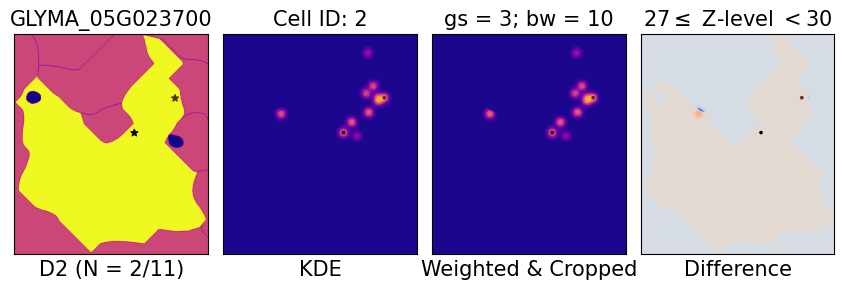

In [13]:
zlevel = len(axes[2])//2-2
fig, ax = plt.subplots(1,4,figsize=(8.5,4), sharex=False, sharey=False)
ax = np.atleast_1d(ax); j = 0

zmask = (ccoords[2] >= axes[2][zlevel]) & (ccoords[2] < axes[2][zlevel+1])
ax[j].imshow(cell, cmap='plasma', origin='lower', extent=extent); j+=1
for density in [uwkde,kde]:
    ax[j].contourf(axes[0]+ss[1].start, axes[1]+ss[0].start, density[zlevel,:,:], 16, cmap='plasma', vmin=0, vmax=vmax, zorder=1)
    j += 1
ax[j].contourf(axes[0]+ ss[1].start, axes[1]+ss[0].start, diff[zlevel,:,:], 32, cmap='coolwarm', vmin=-maxd, vmax=maxd)

if np.sum(zmask) > 0:
    ax[0].scatter(ccoords[0][zmask], ccoords[1][zmask], c=w[zmask], cmap='copper', marker='*', 
                  zorder=3, s=25, alpha=1, vmin=1, vmax=wmax);
    for i in range(1,len(ax)):
        ax[i].scatter(ccoords[0][zmask], ccoords[1][zmask], c=w[zmask],
                      cmap='copper', marker='o', s=2.5, alpha=1, zorder=3, vmin=1, vmax=wmax)
    
for a in ax.ravel():
    a.set_aspect('equal')
    a.margins(0)
    a.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

ax[0].set_xlabel('{} (N = {}/{})'.format(sample, np.sum(zmask), len(ccoords[0])), fontsize=fs)
ax[1].set_xlabel('KDE', fontsize=fs)
ax[2].set_xlabel('Weighted & Cropped', fontsize=fs)
ax[3].set_xlabel('Difference', fontsize=fs)

ax[0].set_title(transcriptomes[tidx], fontsize=fs)
ax[1].set_title('Cell ID: {}'.format(metacell.loc[cidx, 'orig_cellID']), fontsize=fs)
ax[2].set_title('gs = {}; bw = {}'.format(stepsize, bw), fontsize=fs)
ax[3].set_title('${}\leq$ Z-level $< {}$'.format(*axes[2][zlevel:zlevel+2]), fontsize=fs)

fig.tight_layout();

#filename = '{}{}_{}_{}_{}_3D_kde_correction_z{:02d}'.format(figdst,sample,transcriptomes[tidx],metacell.loc[cidx,'orig_cellID'],cidx,zlevel)
#plt.savefig(filename + '.png', format='png', dpi=96, bbox_inches='tight', transparent=True)

# Cubical persistence

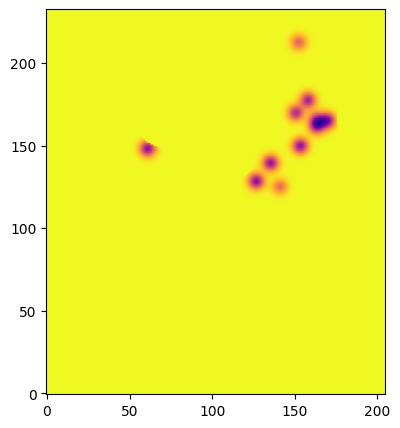

In [14]:
fig, ax = plt.subplots(1,1,figsize=(5,5), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

ax[0].imshow(kde[len(axes[2])//2-2,:,:], origin='lower', cmap='plasma_r', vmin=0, zorder=1);

In [15]:
print(np.min(kde), np.max(kde), kde.shape, len(metacell))

0.0 9.519646234636512e-06 (22, 233, 205) 2937


In [16]:
cc = gd.CubicalComplex(top_dimensional_cells = kde)
pers = cc.persistence(homology_coeff_field=2, min_persistence=1e-15)
print(len(pers))
pers

20


[(2, (5.307101003142905e-07, 9.519646234636512e-06)),
 (2, (5.769972913152482e-08, 6.427544701827364e-06)),
 (2, (3.277271560828956e-07, 5.838221083010622e-06)),
 (2, (2.6152081269873215e-07, 5.586022380917344e-06)),
 (2, (7.471012383292991e-07, 5.585142327116504e-06)),
 (2, (8.650032942548589e-07, 5.679541870524144e-06)),
 (2, (1.301823910523224e-06, 5.592176101011694e-06)),
 (2, (1.9511384382150084e-06, 5.700671408534926e-06)),
 (2, (2.7954193230867233e-06, 5.694752038466497e-06)),
 (1, (0.0, 2.857156064469745e-07)),
 (1, (2.276331864416171e-16, 2.617758175969482e-07)),
 (1, (1.3190860398767321e-08, 2.0476972477902738e-07)),
 (1, (2.4369023854749747e-08, 1.5981107399731308e-07)),
 (1, (4.4713584301811635e-08, 1.483737627581576e-07)),
 (1, (4.02538424041248e-09, 9.834046182297927e-08)),
 (1, (5.646591215611795e-07, 6.480244283582793e-07)),
 (1, (1.641170857504257e-06, 1.6859899636569843e-06)),
 (1, (2.276331563463606e-16, 4.2932983745469345e-08)),
 (1, (3.749841041848543e-08, 6.296815

In [21]:
#filename = '{}{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'.format(tdst,transcriptomes[tidx], dst.split('/')[1], PP,stepsize,bw,cidx)

#filename = '{}{}_-_{}_p{}_s{}_bw{}_c{:06d}.json'.format('../sublevel/D2/',transcriptomes[tidx], 'sub', PP,stepsize,bw,cidx)
print(filename)

with open(filename, 'w') as f:
    json.dump(pers,f)

../sublevel/D2/GLYMA_05G023700_-_sub_p6_s3_bw10_c000001.json


In [30]:
bd = np.zeros((len(pers), 3), dtype=float)
for i in range(len(bd)):
    bd[i, 0] = pers[i][0]
    bd[i, 1:] = pers[i][1]
bd[ bd == np.inf] = vmax

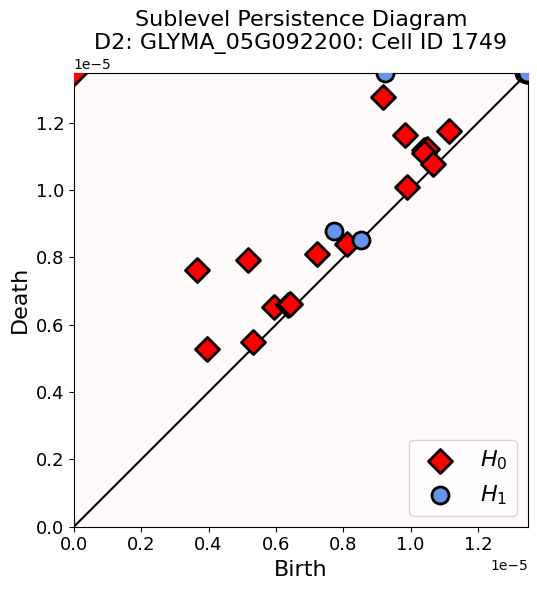

In [32]:
fs = 16; marker = ['D', 'o']; color = ['red','cornflowerblue']
fig, ax = plt.subplots(1,1, figsize=(6,6), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()

for i in range(2):
    mask = bd[:,0] == i
    ax[0].scatter(bd[mask, 1], bd[mask, 2], label='$H_{}$'.format(i), marker=marker[i], 
                  c=color[i], s=150, linewidth=2, edgecolor='k', zorder=i+4)

ax[0].scatter([0, np.max(bd[:,1:])] , [np.max(bd[:,1:]), np.max(bd[:,1:])] , alpha=0)
ax[0].legend(loc='lower right', fontsize=fs)
ax[0].set_aspect(1)
ax[0].axline(xy1=(0,0), slope=1, c='k', zorder=1)
ax[0].tick_params(labelsize=fs-3)
ax[0].set_xlabel('Birth', fontsize=fs)
ax[0].set_ylabel('Death', fontsize=fs)
ax[0].margins(0)
ax[0].set_facecolor('snow')

title = 'Sublevel Persistence Diagram\n{}: {}: Cell ID {}'.format(sample, transcriptomes[tidx], metacell.loc[cidx, 'orig_cellID'])
ax[0].set_title(title, fontsize=fs)

fig.tight_layout()